![NeuronUnit Logo](https://raw.githubusercontent.com/scidash/assets/master/logos/neuronunit.png)
#Chapter 2
Back to [Chapter 1](chapter1.ipynb)

In the first chapter we used a dummy model and simple test to illustrate some basic concepts.  Here we'll use NeuronUnit in a more interesting way: let's validate a real ion channel model's IV (current vs voltage) curve against data from a published experiment.

In [1]:
import os
import sys
sys.path.insert(1,'/Users/rgerkin/Dropbox/dev/ChannelWorm')
import channelworm # ChannelWorm is available at http://github.com/openworm/channelworm
channelworm.django_setup() # Adds all channelworm subdirectories to the path, including ion_channel.  
from ion_channel.models import GraphData # A class to retrieve digitized data from figures.  
from neuronunit.tests.channel import IVCurvePeakTest # A test for the current-voltage relationship 
                                                     # of a neuron or ion channel.
from neuronunit.models.channel import ChannelModel # A SciUnit model class that wraps NeuroML ion channel models.  

###Now let's instantite the ion channel `model`.  
It will be one from a calcium channel whose subunit is thought to be encoded by the EGL-19 gene in C. elegans.

In [2]:
channel_model_name = 'EGL-19.channel' # Name of a NeuroML channel model (corresponds to the name of a NeuroML file).
channel_id = 'ca_boyle' # Identifier for the channel in that NeuroML file.
channel_dir_path = '/Users/rgerkin/Dropbox/dev/ChannelWorm/models' # Location of NeuroML channel files.  
channel_file_path = os.path.join(channel_dir_path, '%s.nml' % channel_model_name) # Location of the current file.  
model = ChannelModel(channel_file_path, channel_index=0, name=channel_model_name) # Instantiate the model.  
                                                                    # channel_index=0 in most cases, unless there
                                                                    # are multiple channels of the same type
                                                                    # in the model file.  

`ChannelModel` is a NeuronUnit `model` class that wraps an ion channel model expressed using [NeuroML](http://neuroml.org) and simulates its dynamics using [jNeuroML](https://github.com/NeuroML/jNeuroML).  **You should install both.**
###As before, all of the interaction with the model is done through its capabilities.  
In this case, those capabilities are inherited in the `ChannelModel` class definition, and implemented in the methods of that class as defined in `neuronunit.models`.  

Now we get an observation of real ion channel behavior to use for our test:

In [3]:
import quantities as pq

doi = '10.1083/jcb.200203055' # A Digital Object Identifier for (in this case) a journal article.  
fig = '2B' # A reference to a figure in that article.  
sample_data = GraphData.objects.get(graph__experiment__reference__doi=doi, 
                                    graph__figure_ref_address=fig) # If that figure has been digitized by the 
                                                                   # ChannelWorm team, we load its data here.  
voltage, current_per_farad = sample_data.asunitedarray() # Extract the voltage and current with units.  
patch_capacitance = pq.Quantity(1e-13,'F') # Assume recorded patch had this capacitance; 
                                           # an arbitrary scaling factor.  
current = current_per_farad * patch_capacitance # Convert from current per unit capacitance into current.  
observation = {'v':voltage, 
               'i':current} # Construct the observation as required by the test.  

Now that we have an observation, we can instantiate our test.  
###How did we know the observation needs the form above?  
It is stated in the tests's docstring, or can be inferred from its optional validate_observation method:
```python
class IVCurveTest(sciunit.Test):
    ...
    def validate_observation(self, observation):
            assert type(observation) is dict
            for item in ['v', 'i']:
                assert item in observation
                assert type(observation[item]) in [list,tuple] \
                    or isinstance(observation[item],np.ndarray)
    ...
```

In [4]:
test = IVCurvePeakTest(observation)

###With the test instantiated, we can now judge the model:

In [5]:
# Judge the model output against the experimental data
score = test.judge(model)

###A `score` object isn't just a number.###
It is also bound to data that allow us to visualize the test result and how the score was reached:

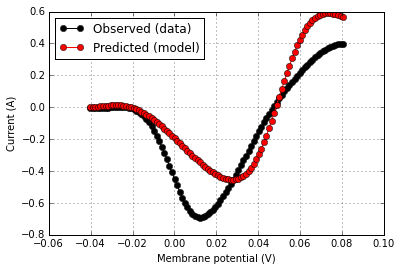

In [6]:
%matplotlib inline
rd = score.related_data
score.plot(rd['v'],rd['i_obs'],color='k',label='Observed (data)')
score.plot(rd['v'],rd['i_pred'],same_fig=True,color='r',label='Predicted (model)')

And we can still get basic information about our score:

In [7]:
score.describe()

The sum-squared difference in the observed and predicted current values over the range of the tested holding potentials.


In [8]:
score.summarize() 

=== Model EGL-19.channel (ChannelModel) achieved score Pass on test 'IV Curve Test (IVCurvePeakTest)'. ===


Really, that's a pass?  Those curves don't look too similar.  What was the criterion for passing?

In [9]:
score.test.converter.description

'Converts a score to pass if its value is at most 100 pA**2, otherwise False.'

###Let's change the threshold for a passing score:

In [10]:
score.test.converter.cutoff = pq.Quantity(0.01,'pA**2')
score = test.converter.convert(score)

Now the score is changed to reflect the new cutoff.  

In [11]:
score.summarize() 

=== Model EGL-19.channel (ChannelModel) achieved score Fail on test 'IV Curve Test (IVCurvePeakTest)'. ===


###On to [Chapter 3](chapter3.ipynb)!